<a href="https://colab.research.google.com/github/LUUTHIENXUAN/Pointnet-plus-plus-in-Tensorflow2/blob/main/Point_cloud_classification_with_PointNet%2B%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Point cloud classification with PointNet++

**Author:** [dgriffiths3](https://github.com/dgriffiths3/pointnet2-tensorflow2)<br>
**Date created:** 2020/05/25<br>
**Last modified:** 2020/05/26<br>
**Description:** Implementation of PointNet++ for ModelNet10 classification.

https://github.com/dgriffiths3/pointnet2-tensorflow2

# Point cloud classification


## Introduction

Classification, detection and segmentation of unordered 3D point sets i.e. point clouds
is a core problem in computer vision. This example implements the seminal point cloud
deep learning paper [PointNet (Qi et al., 2017)](https://arxiv.org/abs/1612.00593). For a
detailed intoduction on PointNet see [this blog
post](https://medium.com/@luis_gonzales/an-in-depth-look-at-pointnet-111d7efdaa1a).


## Setup

If using colab first install trimesh with `!pip install trimesh`.


In [ ]:
!pip install trimesh

     |████████████████████████████████| 639 kB 5.2 MB/s 


In [ ]:
import os
import glob
import trimesh
import numpy as np

#!pip install tensorflow==2.6.0
#!pip install keras==2.6.*
import tensorflow as tf
print(tf.__version__)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

tf.random.set_seed(1234)

2.7.0


## Load dataset

We use the ModelNet10 model dataset, the smaller 10 class version of the ModelNet40
dataset. First download the data:


In [ ]:
DATA_DIR = tf.keras.utils.get_file(
    "modelnet.zip",
    "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip",
    extract=True,
)
DATA_DIR = os.path.join(os.path.dirname(DATA_DIR), "ModelNet10")

473415680/473402300 [==============================] - 7s 0us/step


We can use the `trimesh` package to read and visualize the `.off` mesh files.


In [ ]:
mesh = trimesh.load(os.path.join(DATA_DIR, "chair/train/chair_0001.off"))
mesh.show()

To convert a mesh file to a point cloud we first need to sample points on the mesh
surface. `.sample()` performs a unifrom random sampling. Here we sample at 2048 locations
and visualize in `matplotlib`.


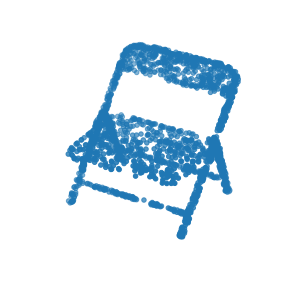

In [ ]:
points = mesh.sample(2048)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_axis_off()
plt.show()

To generate a `tf.data.Dataset()` we need to first parse through the ModelNet data
folders. Each mesh is loaded and sampled into a point cloud before being added to a
standard python list and converted to a `numpy` array. We also store the current
enumerate index value as the object label and use a dictionary to recall this later.


In [ ]:
def parse_dataset(num_points=2048):

  train_points = []
  train_labels = []
  test_points = []
  test_labels = []
  class_map   = {}
  folders = glob.glob(os.path.join(DATA_DIR, "[!README]*"))

  for i, folder in enumerate(folders):
    print("processing class: {}".format(os.path.basename(folder)))
    # store folder name with ID so we can retrieve later
    class_map[i] = folder.split("/")[-1]
    
    # gather all files
    train_files = glob.glob(os.path.join(folder, "train/*"))
    test_files  = glob.glob(os.path.join(folder, "test/*"))

    for f in train_files:
      train_points.append(trimesh.load(f).sample(num_points))
      train_labels.append(i)

    for f in test_files:
      test_points.append(trimesh.load(f).sample(num_points))
      test_labels.append(i)

  return (np.array(train_points),np.array(test_points),np.array(train_labels),np.array(test_labels),class_map,)

Set the number of points to sample and batch size and parse the dataset. This can take
~5minutes to complete.


In [ ]:
NUM_POINTS  = 2048
NUM_CLASSES = 10
BATCH_SIZE  = 32

train_points, test_points, train_labels, test_labels, CLASS_MAP = parse_dataset(NUM_POINTS)

processing class: desk
processing class: bed
processing class: night_stand
processing class: dresser
processing class: toilet
processing class: chair
processing class: bathtub
processing class: table
processing class: monitor
processing class: sofa


Our data can now be read into a `tf.data.Dataset()` object. We set the shuffle buffer
size to the entire size of the dataset as prior to this the data is ordered by class.
Data augmentation is important when working with point cloud data. We create a
augmentation function to jitter and shuffle the train dataset.


In [ ]:
def augment(points, label):
  # jitter points
  points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
  # shuffle points
  points = tf.random.shuffle(points)
  return points, label


train_dataset = tf.data.Dataset.from_tensor_slices((train_points, train_labels))
test_dataset  = tf.data.Dataset.from_tensor_slices((test_points, test_labels))

train_dataset = train_dataset.shuffle(len(train_points)).map(augment).batch(BATCH_SIZE)
test_dataset  = test_dataset.shuffle(len(test_points)).batch(BATCH_SIZE)

##Build a model Pointnet

Each convolution and fully-connected layer (with exception for end layers) consits of
*   Convolution / Dense
*   Batch Normalization
*   ReLU Activation



In [ ]:
class Conv_Bn(tf.keras.layers.Layer):
  def __init__(self,filters,mom=0.0,acti="relu"):
    super(Conv_Bn, self).__init__()
    self.conv = tf.keras.layers.Conv1D(filters,kernel_size=1,padding="valid")
    self.bat  = tf.keras.layers.BatchNormalization(momentum= mom)
    self.act  = tf.keras.layers.Activation(acti) 
    
  @tf.function(experimental_compile=True)
  def __call__(self, x):
    x = self.conv(x)
    x = self.bat(x)
    return self.act(x)

class Dense_Bn(tf.keras.layers.Layer):
  def __init__(self,filters,mom=0.0,acti="relu"):
    super(Dense_Bn, self).__init__()

    self.den = tf.keras.layers.Dense(filters)
    self.bat = tf.keras.layers.BatchNormalization(momentum=mom)
    self.act = tf.keras.layers.Activation(acti)

  @tf.function(experimental_compile=True)
  def __call__(self, x):
    x = self.den(x)
    x = self.bat(x)
    return self.act(x)

PointNet consists of two core components. The primary MLP network, and the transformer
net (T-net). 

The T-net aims to learn an affine transformation matrix by its own mini network. The T-net is used twice. 

* The first time to transform the input features (n, 3) into a canonical representation. 
* The second is an affine transformation for alignment in feature space (n, 3). 

As per the original paper we constrain the transformation to be close to an orthogonal matrix (i.e. ||X*X^T - I|| = 0).


In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
  def __init__(self, num_features, l2reg=0.001):
    self.num_features = num_features
    self.l2reg = l2reg
    self.eye = tf.eye(num_features)
    
  @tf.function(experimental_compile=True)
  def __call__(self, x):
    x = tf.reshape(x, (-1, self.num_features, self.num_features))
    xxt = tf.tensordot(x, x, axes=(2, 2))
    xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
    return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

 We can then define a general function to build T-net layers.


The main network can be then implemented in the same manner where the t-net mini models
can be dropped in a layers in the graph. Here we replicate the network architecture
published in the original paper but with half the number of weights at each layer as we
are using the smaller 10 class ModelNet dataset.


In [ ]:
class Tnet(tf.keras.layers.Layer):
  def __init__(self, num_features):
    super(Tnet, self).__init__()
    # Initalise bias as the indentity matrix
    self.bias = tf.keras.initializers.Constant(np.eye(num_features).flatten())
    self.reg  = OrthogonalRegularizer(num_features)
    self.num_features = num_features
    self.conv_bn0 = Conv_Bn(filters=32)
    self.conv_bn1 = Conv_Bn(filters=64)
    self.conv_bn2 = Conv_Bn(filters=512)
    self.globalmax = tf.keras.layers.GlobalMaxPooling1D()
    self.dense_bn0 = Dense_Bn(filters=256)
    self.dense_bn1 = Dense_Bn(filters=128)
    self.dense_0 = tf.keras.layers.Dense(self.num_features*self.num_features,
                                         kernel_initializer="zeros",
                                         bias_initializer=self.bias,
                                         activity_regularizer=self.reg)
    self.reshape = tf.keras.layers.Reshape((self.num_features, self.num_features))

  @tf.function(experimental_compile=True)
  def call(self, inputs):
    x = self.conv_bn0(inputs)
    x = self.conv_bn1(x)
    x = self.conv_bn2(x)
    x = self.globalmax(x)
    x = self.dense_bn0(x)
    x = self.dense_bn1(x)
    x = self.dense_0(x)

    feat_T = self.reshape(x)
    # Apply affine transformation to input features
    return tf.keras.layers.Dot(axes=(2, 1))([inputs, feat_T])

In [ ]:
class PointNet(tf.keras.Model):
  def __init__(self, NUM_CLASSES, input_shape=(None,NUM_POINTS, 3), **kwargs):
        
    super(PointNet, self).__init__(input_shape, **kwargs)
    self.tnet0 = Tnet(3)
    self.tnet1 = Tnet(32)

    self.conv_bn00  = Conv_Bn(filters=32)
    self.conv_bn01 = Conv_Bn(filters=32)
    self.conv_bn02 = Conv_Bn(filters=32)

    self.conv_bn1  = Conv_Bn(filters=64)
    self.conv_bn2  = Conv_Bn(filters=512)
    self.dense_bn0 = Dense_Bn(filters=256)
    self.dense_bn1 = Dense_Bn(filters=128)

    self.dropout = tf.keras.layers.Dropout(0.3)
    self.globalmax = tf.keras.layers.GlobalMaxPooling1D()
    self.dense = tf.keras.layers.Dense(NUM_CLASSES, activation="softmax")
    
  @tf.function(experimental_compile=True)
  def call(self, inputs):
    x = self.tnet0(inputs)  
    x = self.conv_bn00(x)
    x = self.conv_bn01(x)
    x = self.tnet1(x)
    x = self.conv_bn02(x)
    x = self.conv_bn1(x)
    x = self.conv_bn2(x)
    x = self.globalmax(x)
    x = self.dense_bn0(x)
    x = self.dropout(x)
    x = self.dense_bn1(x)
    x = self.dropout(x)
    x = self.dense(x)
    return x

model = PointNet(NUM_CLASSES)
model.build(input_shape=(None, NUM_POINTS,3))
model.summary()

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model.fit(train_dataset, epochs=20, validation_data=test_dataset)

## Build a model Pointnet++

In [ ]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl 

###tf_ops

In [ ]:
!mkdir tf_ops

####tf_interpolate

In [ ]:
!mkdir ./tf_ops/3d_interpolation

In [ ]:
%%writefile ./tf_ops/3d_interpolation/tf_interpolate.cpp

#include <cstdio>
#include <ctime>
#include <cstring> // memset
#include <cstdlib> // rand, RAND_MAX
#include <cmath> // sqrtf
#include "tensorflow/core/framework/op.h"
#include "tensorflow/core/framework/op_kernel.h"
#include "tensorflow/core/framework/shape_inference.h"
#include "tensorflow/core/framework/common_shape_fns.h"
using namespace tensorflow;

REGISTER_OP("ThreeNN")
    .Input("xyz1: float32")
    .Input("xyz2: float32")
    .Output("dist: float32")
    .Output("idx: int32")
    .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
        c->set_output(0, c->input(0));
        c->set_output(1, c->input(0));
        return Status::OK();
    });
REGISTER_OP("ThreeInterpolate")
    .Input("points: float32")
    .Input("idx: int32")
    .Input("weight: float32")
    .Output("out: float32")
    .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
        ::tensorflow::shape_inference::ShapeHandle dims1; // (b,m,c)
        TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 3, &dims1));
        ::tensorflow::shape_inference::ShapeHandle dims2; // (b,n,3)
        TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 3, &dims2));
        // (b,n,c)
        ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims1, 0), c->Dim(dims2, 1), c->Dim(dims1, 2)});
        c->set_output(0, output);
        return Status::OK();
    });
REGISTER_OP("ThreeInterpolateGrad")
    .Input("points: float32")
    .Input("idx: int32")
    .Input("weight: float32")
    .Input("grad_out: float32")
    .Output("grad_points: float32")
    .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
        c->set_output(0, c->input(0));
        return Status::OK();
    });

float randomf(){
    return (rand()+0.5)/(RAND_MAX+1.0);
}
static double get_time(){
    timespec tp;
    clock_gettime(CLOCK_MONOTONIC,&tp);
    return tp.tv_sec+tp.tv_nsec*1e-9;
}

// Find three nearest neigbors with square distance
// input: xyz1 (b,n,3), xyz2(b,m,3)
// output: dist (b,n,3), idx (b,n,3)
void threenn_cpu(int b, int n, int m, const float *xyz1, const float *xyz2, float *dist, int *idx) {
     for (int i=0;i<b;++i) {
        for (int j=0;j<n;++j) {
	    float x1=xyz1[j*3+0];
	    float y1=xyz1[j*3+1];
	    float z1=xyz1[j*3+2];
            double best1=1e40; double best2=1e40; double best3=1e40;
            int besti1=0; int besti2=0; int besti3=0;
            for (int k=0;k<m;++k) {
                float x2=xyz2[k*3+0];
	        float y2=xyz2[k*3+1];
	        float z2=xyz2[k*3+2];
		//float d=max(sqrtf((x2-x1)*(x2-x1)+(y2-y1)*(y2-y1)+(z2-z1)*(z2-z1)),1e-20f);
		double d=(x2-x1)*(x2-x1)+(y2-y1)*(y2-y1)+(z2-z1)*(z2-z1);
                if (d<best1) {
                    best3=best2;
                    besti3=besti2;
                    best2=best1;
                    besti2=besti1;
                    best1=d;
                    besti1=k;
                } else if (d<best2) {
                    best3=best2;
                    besti3=besti2;
                    best2=d;
                    besti2=k;
                } else if (d<best3) {
                    best3=d;
                    besti3=k;
                }
            }
            dist[j*3]=best1;
            idx[j*3]=besti1;
            dist[j*3+1]=best2;
            idx[j*3+1]=besti2;
            dist[j*3+2]=best3;
            idx[j*3+2]=besti3;
        }
        xyz1+=n*3;
        xyz2+=m*3;
        dist+=n*3;
        idx+=n*3;
    }
}

// input: points (b,m,c), idx (b,n,3), weight (b,n,3)
// output: out (b,n,c)
void threeinterpolate_cpu(int b, int m, int c, int n, const float *points, const int *idx, const float *weight, float *out) {
     float w1,w2,w3;
     int i1,i2,i3;
     for (int i=0;i<b;++i) {
        for (int j=0;j<n;++j) {
            w1=weight[j*3];
            w2=weight[j*3+1];
            w3=weight[j*3+2];
            i1=idx[j*3];
            i2=idx[j*3+1];
            i3=idx[j*3+2];
            for (int l=0;l<c;++l) {
                out[j*c+l] = points[i1*c+l]*w1 + points[i2*c+l]*w2 + points[i3*c+l]*w3;
            }
        }
        points+=m*c;
        idx+=n*3;
        weight+=n*3;
        out+=n*c;
    }
}

// input: grad_out (b,n,c), idx (b,n,3), weight (b,n,3)
// output: grad_points (b,m,c)
void threeinterpolate_grad_cpu(int b, int n, int c, int m, const float *grad_out, const int *idx, const float *weight, float *grad_points) {
     float w1,w2,w3;
     int i1,i2,i3;
     for (int i=0;i<b;++i) {
        for (int j=0;j<n;++j) {
            w1=weight[j*3];
            w2=weight[j*3+1];
            w3=weight[j*3+2];
            i1=idx[j*3];
            i2=idx[j*3+1];
            i3=idx[j*3+2];
            for (int l=0;l<c;++l) {
                grad_points[i1*c+l] += grad_out[j*c+l]*w1;
                grad_points[i2*c+l] += grad_out[j*c+l]*w2;
                grad_points[i3*c+l] += grad_out[j*c+l]*w3;
            }
        }
        grad_out+=n*c;
        idx+=n*3;
        weight+=n*3;
        grad_points+=m*c;
    }
}


class ThreeNNOp : public OpKernel {
    public:
        explicit ThreeNNOp(OpKernelConstruction* context) : OpKernel(context) {}

        void Compute(OpKernelContext* context) override {
            const Tensor& xyz1_tensor = context->input(0);
            OP_REQUIRES(context, xyz1_tensor.dims()==3 && xyz1_tensor.shape().dim_size(2)==3, errors::InvalidArgument("ThreeNN expects (b,n,3) xyz1 shape."));
            int b = xyz1_tensor.shape().dim_size(0);
            int n = xyz1_tensor.shape().dim_size(1);

            const Tensor& xyz2_tensor = context->input(1);
            OP_REQUIRES(context, xyz2_tensor.dims()==3 && xyz2_tensor.shape().dim_size(2)==3, errors::InvalidArgument("ThreeNN expects (b,m,3) xyz2 shape."));
            int m = xyz2_tensor.shape().dim_size(1);

            Tensor *dist_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(0, TensorShape{b,n,3}, &dist_tensor));
            Tensor *idx_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(1, TensorShape{b,n,3}, &idx_tensor));

            auto xyz1_flat = xyz1_tensor.flat<float>();
            const float *xyz1 = &(xyz1_flat(0));
            auto xyz2_flat = xyz2_tensor.flat<float>();
            const float *xyz2 = &(xyz2_flat(0));
            auto dist_flat = dist_tensor->flat<float>();
            float *dist = &(dist_flat(0));
            auto idx_flat = idx_tensor->flat<int>();
            int *idx = &(idx_flat(0));
            threenn_cpu(b,n,m,xyz1,xyz2,dist,idx);
        }
};
REGISTER_KERNEL_BUILDER(Name("ThreeNN").Device(DEVICE_CPU), ThreeNNOp);


class ThreeInterpolateOp: public OpKernel{
    public:
        explicit ThreeInterpolateOp(OpKernelConstruction * context):OpKernel(context){}

        void Compute(OpKernelContext * context) override {
            const Tensor& points_tensor=context->input(0);
            OP_REQUIRES(context, points_tensor.dims()==3, errors::InvalidArgument("ThreeInterpolate expects (b,m,c) points shape"));
            int b = points_tensor.shape().dim_size(0);
            int m = points_tensor.shape().dim_size(1);
            int c = points_tensor.shape().dim_size(2);

            const Tensor& idx_tensor=context->input(1);
            OP_REQUIRES(context,idx_tensor.dims()==3 && idx_tensor.shape().dim_size(0)==b && idx_tensor.shape().dim_size(2)==3, errors::InvalidArgument("ThreeInterpolate expects (b,n,3) idx shape"));
            int n = idx_tensor.shape().dim_size(1);
            const Tensor& weight_tensor=context->input(2);
            OP_REQUIRES(context,weight_tensor.dims()==3 && weight_tensor.shape().dim_size(0)==b && weight_tensor.shape().dim_size(1)==n && weight_tensor.shape().dim_size(2)==3, errors::InvalidArgument("ThreeInterpolate expects (b,n,3) weight shape"));

            Tensor * out_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(0,TensorShape{b,n,c}, &out_tensor));

            auto points_flat = points_tensor.flat<float>();
            const float *points = &(points_flat(0));
            auto idx_flat = idx_tensor.flat<int>();
            const int *idx = &(idx_flat(0));
            auto weight_flat = weight_tensor.flat<float>();
            const float *weight = &(weight_flat(0));
            auto out_flat = out_tensor->flat<float>();
            float *out = &(out_flat(0));
            threeinterpolate_cpu(b,m,c,n,points,idx,weight,out);
        }
};
REGISTER_KERNEL_BUILDER(Name("ThreeInterpolate").Device(DEVICE_CPU),ThreeInterpolateOp);


class ThreeInterpolateGradOp: public OpKernel{
    public:
        explicit ThreeInterpolateGradOp(OpKernelConstruction * context):OpKernel(context){}

        void Compute(OpKernelContext * context) override {
            const Tensor& points_tensor=context->input(0);
            OP_REQUIRES(context, points_tensor.dims()==3, errors::InvalidArgument("ThreeInterpolateGrad expects (b,m,c) points shape"));
            int b = points_tensor.shape().dim_size(0);
            int m = points_tensor.shape().dim_size(1);
            int c = points_tensor.shape().dim_size(2);

            const Tensor& idx_tensor=context->input(1);
            OP_REQUIRES(context,idx_tensor.dims()==3 && idx_tensor.shape().dim_size(0)==b, errors::InvalidArgument("ThreeInterpolateGrad expects (b,n,3) idx shape"));
            int n = idx_tensor.shape().dim_size(1);
            const Tensor& weight_tensor=context->input(2);
            OP_REQUIRES(context,weight_tensor.dims()==3 && weight_tensor.shape().dim_size(0)==b && weight_tensor.shape().dim_size(1)==n && weight_tensor.shape().dim_size(2)==3, errors::InvalidArgument("ThreeInterpolateGrad expects (b,n,3) weight shape"));

            const Tensor& grad_out_tensor=context->input(3);
            OP_REQUIRES(context,grad_out_tensor.dims()==3 && grad_out_tensor.shape().dim_size(0)==b && grad_out_tensor.shape().dim_size(1)==n && grad_out_tensor.shape().dim_size(2)==c, errors::InvalidArgument("ThreeInterpolateGrad expects (b,n,c) grad_out shape"));

            Tensor * grad_points_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(0,TensorShape{b,m,c}, &grad_points_tensor));

            auto points_flat = points_tensor.flat<float>();
            const float *points = &(points_flat(0));
            auto idx_flat = idx_tensor.flat<int>();
            const int *idx = &(idx_flat(0));
            auto weight_flat = weight_tensor.flat<float>();
            const float *weight = &(weight_flat(0));
            auto grad_out_flat = grad_out_tensor.flat<float>();
            const float *grad_out = &(grad_out_flat(0));
            auto grad_points_flat = grad_points_tensor->flat<float>();
            float *grad_points = &(grad_points_flat(0));
            memset(grad_points, 0, sizeof(float)*b*m*c);
            threeinterpolate_grad_cpu(b,n,c,m,grad_out,idx,weight,grad_points);
        }
};
REGISTER_KERNEL_BUILDER(Name("ThreeInterpolateGrad").Device(DEVICE_CPU),ThreeInterpolateGradOp);

Writing ./tf_ops/3d_interpolation/tf_interpolate.cpp


####tf_grouping

In [ ]:
!mkdir ./tf_ops/grouping

In [ ]:
%%writefile ./tf_ops/grouping/tf_grouping.cpp

#include <cstdio>
#include <ctime>
#include <cstring> // memset
#include <cstdlib> // rand, RAND_MAX
#include <cmath> // sqrtf
#include "tensorflow/core/framework/op.h"
#include "tensorflow/core/framework/op_kernel.h"
#include "tensorflow/core/framework/shape_inference.h"
#include "tensorflow/core/framework/common_shape_fns.h"
#include <cuda_runtime.h>
using namespace tensorflow;

REGISTER_OP("QueryBallPoint")
    .Attr("radius: float")
    .Attr("nsample: int")
    .Input("xyz1: float32")
    .Input("xyz2: float32")
    .Output("idx: int32")
    .Output("pts_cnt: int32")
    .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
        ::tensorflow::shape_inference::ShapeHandle dims2; // batch_size * npoint * 3
        TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 3, &dims2));
        int nsample;
        TF_RETURN_IF_ERROR(c->GetAttr("nsample", &nsample));
        ::tensorflow::shape_inference::ShapeHandle output1 = c->MakeShape({c->Dim(dims2, 0), c->Dim(dims2, 1), nsample});
        c->set_output(0, output1);
        ::tensorflow::shape_inference::ShapeHandle output2 = c->MakeShape({c->Dim(dims2, 0), c->Dim(dims2, 1)});
        c->set_output(1, output2);
        return Status::OK();
    });
REGISTER_OP("SelectionSort")
    .Attr("k: int")
    .Input("dist: float32")
    .Output("outi: int32")
    .Output("out: float32")
    .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
        c->set_output(0, c->input(0));
        c->set_output(1, c->input(0));
        return Status::OK();
    });
REGISTER_OP("GroupPoint")
    .Input("points: float32")
    .Input("idx: int32")
    .Output("out: float32")
    .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
        ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * ndataset * channels
        TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 3, &dims1));
        ::tensorflow::shape_inference::ShapeHandle dims2; // batch_size * npoints * nsample
        TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 3, &dims2));
        // batch_size * npoints * nsample * channels
        ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims2, 0), c->Dim(dims2, 1), c->Dim(dims2, 2), c->Dim(dims1, 2)});
        c->set_output(0, output);
        return Status::OK();
    });
REGISTER_OP("GroupPointGrad")
    .Input("points: float32")
    .Input("idx: int32")
    .Input("grad_out: float32")
    .Output("grad_points: float32")
    .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
        c->set_output(0, c->input(0));
        return Status::OK();
    });


void queryBallPointLauncher(int b, int n, int m, float radius, int nsample, const float *xyz1, const float *xyz2, int *idx, int *pts_cnt);
class QueryBallPointGpuOp : public OpKernel {
    public:
        explicit QueryBallPointGpuOp(OpKernelConstruction* context) : OpKernel(context) {
            OP_REQUIRES_OK(context, context->GetAttr("radius", &radius_));
            OP_REQUIRES(context, radius_ > 0, errors::InvalidArgument("QueryBallPoint expects positive radius"));

            OP_REQUIRES_OK(context, context->GetAttr("nsample", &nsample_));
            OP_REQUIRES(context, nsample_ > 0, errors::InvalidArgument("QueryBallPoint expects positive nsample"));
        }

        void Compute(OpKernelContext* context) override {
            const Tensor& xyz1_tensor = context->input(0);
            OP_REQUIRES(context, xyz1_tensor.dims()==3 && xyz1_tensor.shape().dim_size(2)==3, errors::InvalidArgument("QueryBallPoint expects (batch_size, ndataset, 3) xyz1 shape."));
            int b = xyz1_tensor.shape().dim_size(0);
            int n = xyz1_tensor.shape().dim_size(1);

            const Tensor& xyz2_tensor = context->input(1);
            OP_REQUIRES(context, xyz2_tensor.dims()==3 && xyz2_tensor.shape().dim_size(2)==3, errors::InvalidArgument("QueryBallPoint expects (batch_size, npoint, 3) xyz2 shape."));
            int m = xyz2_tensor.shape().dim_size(1);

            Tensor *idx_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(0, TensorShape{b,m,nsample_}, &idx_tensor));
            Tensor *pts_cnt_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(1, TensorShape{b,m}, &pts_cnt_tensor));

            auto xyz1_flat = xyz1_tensor.flat<float>();
            const float *xyz1 = &(xyz1_flat(0));
            auto xyz2_flat = xyz2_tensor.flat<float>();
            const float *xyz2 = &(xyz2_flat(0));
            auto idx_flat = idx_tensor->flat<int>();
            int *idx = &(idx_flat(0));
            auto pts_cnt_flat = pts_cnt_tensor->flat<int>();
            int *pts_cnt = &(pts_cnt_flat(0));
            queryBallPointLauncher(b,n,m,radius_,nsample_,xyz1,xyz2,idx,pts_cnt);
        }
    private:
        float radius_;
        int nsample_;
};
REGISTER_KERNEL_BUILDER(Name("QueryBallPoint").Device(DEVICE_GPU), QueryBallPointGpuOp);

void selectionSortLauncher(int b, int n, int m, int k, const float *dist, int *outi, float *out);
class SelectionSortGpuOp : public OpKernel {
    public:
        explicit SelectionSortGpuOp(OpKernelConstruction* context) : OpKernel(context) {
            OP_REQUIRES_OK(context, context->GetAttr("k", &k_));
            OP_REQUIRES(context, k_ > 0, errors::InvalidArgument("SelectionSort expects positive k"));
        }

        void Compute(OpKernelContext* context) override {
            const Tensor& dist_tensor = context->input(0);
            OP_REQUIRES(context, dist_tensor.dims()==3, errors::InvalidArgument("SelectionSort expects (b,m,n) dist shape."));
            int b = dist_tensor.shape().dim_size(0);
            int m = dist_tensor.shape().dim_size(1);
            int n = dist_tensor.shape().dim_size(2);

            Tensor *outi_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(0, TensorShape{b,m,n}, &outi_tensor));
            Tensor *out_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(1, TensorShape{b,m,n}, &out_tensor));

            auto dist_flat = dist_tensor.flat<float>();
            const float *dist = &(dist_flat(0));
            auto outi_flat = outi_tensor->flat<int>();
            int *outi = &(outi_flat(0));
            auto out_flat = out_tensor->flat<float>();
            float *out = &(out_flat(0));
            selectionSortLauncher(b,n,m,k_,dist,outi,out);
        }
    private:
        int k_;
};
REGISTER_KERNEL_BUILDER(Name("SelectionSort").Device(DEVICE_GPU), SelectionSortGpuOp);


void groupPointLauncher(int b, int n, int c, int m, int nsample, const float *points, const int *idx, float *out);
class GroupPointGpuOp: public OpKernel{
    public:
        explicit GroupPointGpuOp(OpKernelConstruction * context):OpKernel(context){}

        void Compute(OpKernelContext * context) override {
            const Tensor& points_tensor=context->input(0);
            OP_REQUIRES(context, points_tensor.dims()==3, errors::InvalidArgument("GroupPoint expects (batch_size, num_points, channel) points shape"));
            int b = points_tensor.shape().dim_size(0);
            int n = points_tensor.shape().dim_size(1);
            int c = points_tensor.shape().dim_size(2);

            const Tensor& idx_tensor=context->input(1);
            OP_REQUIRES(context,idx_tensor.dims()==3 && idx_tensor.shape().dim_size(0)==b, errors::InvalidArgument("GroupPoint expects (batch_size, npoints, nsample) idx shape"));
            int m = idx_tensor.shape().dim_size(1);
            int nsample = idx_tensor.shape().dim_size(2);

            Tensor * out_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(0,TensorShape{b,m,nsample,c}, &out_tensor));

            auto points_flat = points_tensor.flat<float>();
            const float *points = &(points_flat(0));
            auto idx_flat = idx_tensor.flat<int>();
            const int *idx = &(idx_flat(0));
            auto out_flat = out_tensor->flat<float>();
            float *out = &(out_flat(0));
            groupPointLauncher(b,n,c,m,nsample,points,idx,out);
        }
};
REGISTER_KERNEL_BUILDER(Name("GroupPoint").Device(DEVICE_GPU),GroupPointGpuOp);

void groupPointGradLauncher(int b, int n, int c, int m, int nsample, const float *grad_out, const int *idx, float *grad_points);
class GroupPointGradGpuOp: public OpKernel{
    public:
        explicit GroupPointGradGpuOp(OpKernelConstruction * context):OpKernel(context){}

        void Compute(OpKernelContext * context) override {
            const Tensor& points_tensor=context->input(0);
            OP_REQUIRES(context, points_tensor.dims()==3, errors::InvalidArgument("GroupPointGrad expects (batch_size, num_points, channel) points shape"));
            int b = points_tensor.shape().dim_size(0);
            int n = points_tensor.shape().dim_size(1);
            int c = points_tensor.shape().dim_size(2);

            const Tensor& idx_tensor=context->input(1);
            OP_REQUIRES(context,idx_tensor.dims()==3 && idx_tensor.shape().dim_size(0)==b, errors::InvalidArgument("GroupPointGrad expects (batch_size, npoints, nsample) idx shape"));
            int m = idx_tensor.shape().dim_size(1);
            int nsample = idx_tensor.shape().dim_size(2);

            const Tensor& grad_out_tensor=context->input(2);
            OP_REQUIRES(context,grad_out_tensor.dims()==4 && grad_out_tensor.shape().dim_size(0)==b && grad_out_tensor.shape().dim_size(1)==m && grad_out_tensor.shape().dim_size(2)==nsample && grad_out_tensor.shape().dim_size(3)==c, errors::InvalidArgument("GroupPointGrad expects (batch_size, npoints, nsample, channel) grad_out shape"));

            Tensor * grad_points_tensor = nullptr;
            OP_REQUIRES_OK(context, context->allocate_output(0,TensorShape{b,n,c}, &grad_points_tensor));

            auto points_flat = points_tensor.flat<float>();
            const float *points = &(points_flat(0));
            auto idx_flat = idx_tensor.flat<int>();
            const int *idx = &(idx_flat(0));
            auto grad_out_flat = grad_out_tensor.flat<float>();
            const float *grad_out = &(grad_out_flat(0));
            auto grad_points_flat = grad_points_tensor->flat<float>();
            float *grad_points = &(grad_points_flat(0));
            cudaMemset(grad_points, 0, sizeof(float)*b*n*c);
            groupPointGradLauncher(b,n,c,m,nsample,grad_out,idx,grad_points);
        }
};
REGISTER_KERNEL_BUILDER(Name("GroupPointGrad").Device(DEVICE_GPU),GroupPointGradGpuOp);

Writing ./tf_ops/grouping/tf_grouping.cpp


In [ ]:
%%writefile ./tf_ops/grouping/tf_grouping_g.cu

// input: radius (1), nsample (1), xyz1 (b,n,3), xyz2 (b,m,3)
// output: idx (b,m,nsample), pts_cnt (b,m)
__global__ void query_ball_point_gpu(int b, int n, int m, float radius, int nsample, const float *xyz1, const float *xyz2, int *idx, int *pts_cnt) {
    int batch_index = blockIdx.x;
    xyz1 += n*3*batch_index;
    xyz2 += m*3*batch_index;
    idx += m*nsample*batch_index;
    pts_cnt += m*batch_index; // counting how many unique points selected in local region

    int index = threadIdx.x;
    int stride = blockDim.x;
    
    for (int j=index;j<m;j+=stride) {
        int cnt = 0;
        for (int k=0;k<n;++k) {
            if (cnt == nsample)
                break; // only pick the FIRST nsample points in the ball
            float x2=xyz2[j*3+0];
            float y2=xyz2[j*3+1];
            float z2=xyz2[j*3+2];
            float x1=xyz1[k*3+0];
            float y1=xyz1[k*3+1];
            float z1=xyz1[k*3+2];
    	    float d=max(sqrtf((x2-x1)*(x2-x1)+(y2-y1)*(y2-y1)+(z2-z1)*(z2-z1)),1e-20f);
            if (d<radius) {
                if (cnt==0) { // set ALL indices to k, s.t. if there are less points in ball than nsample, we still have valid (repeating) indices
                    for (int l=0;l<nsample;++l)
                        idx[j*nsample+l] = k;
                }
                idx[j*nsample+cnt] = k;
                cnt+=1;
            }
        }
        pts_cnt[j] = cnt;
    }
}

// input: points (b,n,c), idx (b,m,nsample)
// output: out (b,m,nsample,c)
__global__ void group_point_gpu(int b, int n, int c, int m, int nsample, const float *points, const int *idx, float *out) {
    int batch_index = blockIdx.x;
    points += n*c*batch_index;
    idx += m*nsample*batch_index;
    out += m*nsample*c*batch_index;

    int index = threadIdx.x;
    int stride = blockDim.x;
    
    for (int j=index;j<m;j+=stride) {
        for (int k=0;k<nsample;++k) {
            int ii = idx[j*nsample+k];
            for (int l=0;l<c;++l) {
                out[j*nsample*c+k*c+l] = points[ii*c+l];
            }
        }
    }
}

// input: grad_out (b,m,nsample,c), idx (b,m,nsample), 
// output: grad_points (b,n,c)
__global__ void group_point_grad_gpu(int b, int n, int c, int m, int nsample, const float *grad_out, const int *idx, float *grad_points) {
    int batch_index = blockIdx.x;
    idx += m*nsample*batch_index;
    grad_out += m*nsample*c*batch_index;
    grad_points += n*c*batch_index;

    int index = threadIdx.x;
    int stride = blockDim.x;

    for (int j=index;j<m;j+=stride) {
        for (int k=0;k<nsample;++k) {
            int ii = idx[j*nsample+k];
            for (int l=0;l<c;++l) {
                 atomicAdd(&grad_points[ii*c+l], grad_out[j*nsample*c+k*c+l]);
            }
        }
    }
}

// input: k (1), distance matrix dist (b,m,n)
// output: idx (b,m,n), dist_out (b,m,n)
// only the top k results within n are useful
__global__ void selection_sort_gpu(int b, int n, int m, int k, const float *dist, int *outi, float *out) {
    int batch_index = blockIdx.x;
    dist+=m*n*batch_index;
    outi+=m*n*batch_index;
    out+=m*n*batch_index;

    int index = threadIdx.x;
    int stride = blockDim.x;

    // copy from dist to dist_out
    for (int j=index;j<m;j+=stride) {
        for (int s=0;s<n;++s) {
            out[j*n+s] = dist[j*n+s];
            outi[j*n+s] = s;
        }
    }

    float *p_dist;
    for (int j=index;j<m;j+=stride) {
        p_dist = out+j*n;
        // selection sort for the first k elements
        for (int s=0;s<k;++s) {
            int min=s; 
            // find the min
            for (int t=s+1;t<n;++t) {
                if (p_dist[t]<p_dist[min]) {
                    min = t;
                }
            }
            // swap min-th and i-th element
            if (min!=s) {
                float tmp = p_dist[min];
                p_dist[min] = p_dist[s];
                p_dist[s] = tmp;
                int tmpi = outi[j*n+min];
                outi[j*n+min] = outi[j*n+s];
                outi[j*n+s] = tmpi;
            }
        }
    }
}

void queryBallPointLauncher(int b, int n, int m, float radius, int nsample, const float *xyz1, const float *xyz2, int *idx, int *pts_cnt) {
    query_ball_point_gpu<<<b,256>>>(b,n,m,radius,nsample,xyz1,xyz2,idx,pts_cnt);
    //cudaDeviceSynchronize();
}
void selectionSortLauncher(int b, int n, int m, int k, const float *dist, int *outi, float *out) {
    selection_sort_gpu<<<b,256>>>(b,n,m,k,dist,outi,out); 
    //cudaDeviceSynchronize();
}
void groupPointLauncher(int b, int n, int c, int m, int nsample, const float *points, const int *idx, float *out){
    group_point_gpu<<<b,256>>>(b,n,c,m,nsample,points,idx,out);
    //cudaDeviceSynchronize();
}
void groupPointGradLauncher(int b, int n, int c, int m, int nsample, const float *grad_out, const int *idx, float *grad_points){
    group_point_grad_gpu<<<b,256>>>(b,n,c,m,nsample,grad_out,idx,grad_points);
    //group_point_grad_gpu<<<1,1>>>(b,n,c,m,nsample,grad_out,idx,grad_points);
    //cudaDeviceSynchronize();
}

Writing ./tf_ops/grouping/tf_grouping_g.cu


####tf_sampling

In [ ]:
!mkdir ./tf_ops/sampling

In [ ]:
%%writefile ./tf_ops/sampling/tf_sampling.cpp

/* Furthest point sampling
 * Original author: Haoqiang Fan
 * Modified by Charles R. Qi
 * All Rights Reserved. 2017.
 */
#include "tensorflow/core/framework/op.h"
#include "tensorflow/core/framework/op_kernel.h"
#include "tensorflow/core/framework/shape_inference.h"
#include "tensorflow/core/framework/common_shape_fns.h"
#include <cuda_runtime.h>

using namespace tensorflow;

REGISTER_OP("ProbSample")
  .Input("inp: float32")
  .Input("inpr: float32")
  .Output("out: int32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * ncategory
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 2, &dims1));
    ::tensorflow::shape_inference::ShapeHandle dims2; // batch_size * npoints
    TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 2, &dims2));
    // batch_size * npoints
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims2, 0), c->Dim(dims2, 1)});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("FarthestPointSample")
  .Attr("npoint: int")
  .Input("inp: float32")
  .Output("out: int32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * npoint * 3
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 3, &dims1));
    int npoint;
    TF_RETURN_IF_ERROR(c->GetAttr("npoint", &npoint));
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims1, 0), npoint});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("GatherPoint")
  .Input("inp: float32")
  .Input("idx: int32")
  .Output("out: float32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    ::tensorflow::shape_inference::ShapeHandle dims1; // batch_size * ndataset * 3
    TF_RETURN_IF_ERROR(c->WithRank(c->input(0), 3, &dims1));
    ::tensorflow::shape_inference::ShapeHandle dims2; // batch_size * npoints
    TF_RETURN_IF_ERROR(c->WithRank(c->input(1), 2, &dims2));
    // batch_size * npoints * 3
    ::tensorflow::shape_inference::ShapeHandle output = c->MakeShape({c->Dim(dims1, 0), c->Dim(dims2, 1), c->Dim(dims1, 2)});
    c->set_output(0, output);
    return Status::OK();
  });
REGISTER_OP("GatherPointGrad")
  .Input("inp: float32")
  .Input("idx: int32")
  .Input("out_g: float32")
  .Output("inp_g: float32")
  .SetShapeFn([](::tensorflow::shape_inference::InferenceContext* c) {
    c->set_output(0, c->input(0));
    return Status::OK();
  });

void probsampleLauncher(int b,int n,int m,const float * inp_p,const float * inp_r,float * temp,int * out);
class ProbSampleGpuOp: public OpKernel{
  public:
    explicit ProbSampleGpuOp(OpKernelConstruction* context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      const Tensor& inpr_tensor=context->input(1);
      auto inp_flat=inp_tensor.flat<float>();
      auto inpr_flat=inpr_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      const float * inpr=&(inpr_flat(0));
      OP_REQUIRES(context,inp_tensor.dims()==2,errors::InvalidArgument("ProbSample expects (batch_size,num_choices) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      OP_REQUIRES(context,inpr_tensor.dims()==2 && inpr_tensor.shape().dim_size(0)==b,errors::InvalidArgument("ProbSample expects (batch_size,num_points) inpr shape"));
      int m=inpr_tensor.shape().dim_size(1);
      Tensor * out_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m},&out_tensor));
      auto out_flat=out_tensor->flat<int>();
      int * out=&(out_flat(0));
      Tensor temp_tensor;
      OP_REQUIRES_OK(context,context->allocate_temp(DataTypeToEnum<float>::value,TensorShape{b,n},&temp_tensor));
      auto temp_flat=temp_tensor.flat<float>();
      float * temp=&(temp_flat(0));
      probsampleLauncher(b,n,m,inp,inpr,temp,out);
    }
};
REGISTER_KERNEL_BUILDER(Name("ProbSample").Device(DEVICE_GPU), ProbSampleGpuOp);

void farthestpointsamplingLauncher(int b,int n,int m,const float * inp,float * temp,int * out);
class FarthestPointSampleGpuOp: public OpKernel{
  public:
    explicit FarthestPointSampleGpuOp(OpKernelConstruction* context):OpKernel(context) {
                    OP_REQUIRES_OK(context, context->GetAttr("npoint", &npoint_));
                    OP_REQUIRES(context, npoint_ > 0, errors::InvalidArgument("FarthestPointSample expects positive npoint"));
                }
    void Compute(OpKernelContext * context)override{
      int m = npoint_;

      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("FarthestPointSample expects (batch_size,num_points,3) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      Tensor * out_tensor;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m},&out_tensor));
      auto out_flat=out_tensor->flat<int>();
      int * out=&(out_flat(0));
      Tensor temp_tensor;
      OP_REQUIRES_OK(context,context->allocate_temp(DataTypeToEnum<float>::value,TensorShape{32,n},&temp_tensor));
      auto temp_flat=temp_tensor.flat<float>();
      float * temp=&(temp_flat(0));
      farthestpointsamplingLauncher(b,n,m,inp,temp,out);
    }
    private:
        int npoint_;
};
REGISTER_KERNEL_BUILDER(Name("FarthestPointSample").Device(DEVICE_GPU),FarthestPointSampleGpuOp);

void gatherpointLauncher(int b,int n,int m,const float * inp,const int * idx,float * out);
class GatherPointGpuOp: public OpKernel{
  public:
    explicit GatherPointGpuOp(OpKernelConstruction * context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPoint expects (batch_size,num_points,3) inp shape"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      const Tensor& idx_tensor=context->input(1);
      OP_REQUIRES(context,idx_tensor.dims()==2 && idx_tensor.shape().dim_size(0)==b,errors::InvalidArgument("GatherPoint expects (batch_size,num_result) idx shape"));
      int m=idx_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      auto idx_flat=idx_tensor.flat<int>();
      const int * idx=&(idx_flat(0));
      Tensor * out_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,m,3},&out_tensor));
      auto out_flat=out_tensor->flat<float>();
      float * out=&(out_flat(0));
      gatherpointLauncher(b,n,m,inp,idx,out);
    }
};
REGISTER_KERNEL_BUILDER(Name("GatherPoint").Device(DEVICE_GPU),GatherPointGpuOp);

void scatteraddpointLauncher(int b,int n,int m,const float * out_g,const int * idx,float * inp_g);
class GatherPointGradGpuOp: public OpKernel{
  public:
    explicit GatherPointGradGpuOp(OpKernelConstruction * context):OpKernel(context){}
    void Compute(OpKernelContext * context)override{
      const Tensor& inp_tensor=context->input(0);
      OP_REQUIRES(context,inp_tensor.dims()==3 && inp_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_points,3) inp"));
      int b=inp_tensor.shape().dim_size(0);
      int n=inp_tensor.shape().dim_size(1);
      const Tensor& idx_tensor=context->input(1);
      OP_REQUIRES(context,idx_tensor.dims()==2 && idx_tensor.shape().dim_size(0)==b,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_result) idx shape"));
      int m=idx_tensor.shape().dim_size(1);
      auto inp_flat=inp_tensor.flat<float>();
      const float * inp=&(inp_flat(0));
      auto idx_flat=idx_tensor.flat<int>();
      const int * idx=&(idx_flat(0));
      const Tensor& out_g_tensor=context->input(2);
      OP_REQUIRES(context,out_g_tensor.dims()==3 && out_g_tensor.shape().dim_size(0)==b && out_g_tensor.shape().dim_size(1)==m && out_g_tensor.shape().dim_size(2)==3,errors::InvalidArgument("GatherPointGradGpuOp expects (batch_size,num_result,3) out_g shape"));
      auto out_g_flat=out_g_tensor.flat<float>();
      const float * out_g=&(out_g_flat(0));
      Tensor * inp_g_tensor=NULL;
      OP_REQUIRES_OK(context,context->allocate_output(0,TensorShape{b,n,3},&inp_g_tensor));
      auto inp_g_flat=inp_g_tensor->flat<float>();
      float * inp_g=&(inp_g_flat(0));
      cudaMemset(inp_g,0,b*n*3*4);
      scatteraddpointLauncher(b,n,m,out_g,idx,inp_g);
    }
};
REGISTER_KERNEL_BUILDER(Name("GatherPointGrad").Device(DEVICE_GPU),GatherPointGradGpuOp);

Writing ./tf_ops/sampling/tf_sampling.cpp


In [ ]:
%%writefile ./tf_ops/sampling/tf_sampling_g.cu

/* Furthest point sampling GPU implementation
 * Original author: Haoqiang Fan
 * Modified by Charles R. Qi
 * All Rights Reserved. 2017. 
 */

__global__ void cumsumKernel(int b,int n,const float * __restrict__ inp,float * __restrict__ out){
  const int BlockSize=2048;
  const int paddingLevel=5;
  __shared__ float buffer4[BlockSize*4];
  __shared__ float buffer[BlockSize+(BlockSize>>paddingLevel)];
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    float runningsum=0,runningsum2=0;
    for (int j=0;j<n;j+=BlockSize*4){
      int n24_i=min(n-j,BlockSize*4);
      int n24=(n24_i+3)&~3;
      int n2=n24>>2;
      for (int k=threadIdx.x*4;k<n24_i;k+=blockDim.x*4){
        if (k+3<n24_i){
          float v1=inp[i*n+j+k];
          float v2=inp[i*n+j+k+1];
          v2+=v1;
          float v3=inp[i*n+j+k+2];
          float v4=inp[i*n+j+k+3];
          v4+=v3;
          v3+=v2;
          v4+=v2;
          buffer4[k]=v1;
          buffer4[k+1]=v2;
          buffer4[k+2]=v3;
          buffer4[k+3]=v4;
          buffer[(k>>2)+(k>>(2+paddingLevel))]=v4;
        }else{
          float v=0;
          for (int k2=k;k2<n24_i;k2++){
            v+=inp[i*n+j+k2];
            buffer4[k2]=v;
          }
          for (int k2=n24_i;k2<n24;k2++){
            buffer4[k2]=v;
          }
          buffer[(k>>2)+(k>>(2+paddingLevel))]=v;
        }
      }
      int u=0;
      for (;(2<<u)<=n2;u++){
        __syncthreads();
        for (int k=threadIdx.x;k<int(n2>>(u+1));k+=blockDim.x){
          int i1=(((k<<1)+2)<<u)-1;
          int i2=(((k<<1)+1)<<u)-1;
          i1+=i1>>paddingLevel;
          i2+=i2>>paddingLevel;
          buffer[i1]+=buffer[i2];
        }
      }
      u--;
      for (;u>=0;u--){
        __syncthreads();
        for (int k=threadIdx.x;k<int((n2-(1<<u))>>(u+1));k+=blockDim.x){
          int i1=(((k<<1)+3)<<u)-1;
          int i2=(((k<<1)+2)<<u)-1;
          i1+=i1>>paddingLevel;
          i2+=i2>>paddingLevel;
          buffer[i1]+=buffer[i2];
        }
      }
      __syncthreads();
      for (int k=threadIdx.x*4;k<n24;k+=blockDim.x*4){
        if (k!=0){
          int k2=((k>>2)-1)+(((k>>2)-1)>>paddingLevel);
          buffer4[k]+=buffer[k2];
          buffer4[k+1]+=buffer[k2];
          buffer4[k+2]+=buffer[k2];
          buffer4[k+3]+=buffer[k2];
        }
      }
      __syncthreads();
      for (int k=threadIdx.x;k<n24_i;k+=blockDim.x){
        out[i*n+j+k]=buffer4[k]+runningsum;
      }
      float t=buffer[(n2-1)+((n2-1)>>paddingLevel)]+runningsum2;
      float r2=runningsum+t;
      runningsum2=t-(r2-runningsum);
      runningsum=r2;
      __syncthreads();
    }
  }
}

__global__ void binarysearchKernel(int b,int n,int m,const float * __restrict__ dataset,const float * __restrict__ query, int * __restrict__ result){
  int base=1;
  while (base<n)
    base<<=1;
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      float q=query[i*m+j]*dataset[i*n+n-1];
      int r=n-1;
      for (int k=base;k>=1;k>>=1)
        if (r>=k && dataset[i*n+r-k]>=q)
          r-=k;
      result[i*m+j]=r;
    }
  }
}
__global__ void farthestpointsamplingKernel(int b,int n,int m,const float * __restrict__ dataset,float * __restrict__ temp,int * __restrict__ idxs){
  if (m<=0)
    return;
  const int BlockSize=512;
  __shared__ float dists[BlockSize];
  __shared__ int dists_i[BlockSize];
  const int BufferSize=3072;
  __shared__ float buf[BufferSize*3];
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    int old=0;
    if (threadIdx.x==0)
      idxs[i*m+0]=old;
    for (int j=threadIdx.x;j<n;j+=blockDim.x){
      temp[blockIdx.x*n+j]=1e38;
    }
    for (int j=threadIdx.x;j<min(BufferSize,n)*3;j+=blockDim.x){
      buf[j]=dataset[i*n*3+j];
    }
    __syncthreads();
    for (int j=1;j<m;j++){
      int besti=0;
      float best=-1;
      float x1=dataset[i*n*3+old*3+0];
      float y1=dataset[i*n*3+old*3+1];
      float z1=dataset[i*n*3+old*3+2];
      for (int k=threadIdx.x;k<n;k+=blockDim.x){
        float td=temp[blockIdx.x*n+k];
        float x2,y2,z2;
        if (k<BufferSize){
          x2=buf[k*3+0];
          y2=buf[k*3+1];
          z2=buf[k*3+2];
        }else{
          x2=dataset[i*n*3+k*3+0];
          y2=dataset[i*n*3+k*3+1];
          z2=dataset[i*n*3+k*3+2];
        }
        float d=(x2-x1)*(x2-x1)+(y2-y1)*(y2-y1)+(z2-z1)*(z2-z1);
        float d2=min(d,td);
        if (d2!=td)
          temp[blockIdx.x*n+k]=d2;
        if (d2>best){
          best=d2;
          besti=k;
        }
      }
      dists[threadIdx.x]=best;
      dists_i[threadIdx.x]=besti;
      for (int u=0;(1<<u)<blockDim.x;u++){
        __syncthreads();
        if (threadIdx.x<(blockDim.x>>(u+1))){
          int i1=(threadIdx.x*2)<<u;
          int i2=(threadIdx.x*2+1)<<u;
          if (dists[i1]<dists[i2]){
            dists[i1]=dists[i2];
            dists_i[i1]=dists_i[i2];
          }
        }
      }
      __syncthreads();
      old=dists_i[0];
      if (threadIdx.x==0)
        idxs[i*m+j]=old;
    }
  }
}

__global__ void gatherpointKernel(int b,int n,int m,const float * __restrict__ inp,const int * __restrict__ idx,float * __restrict__ out){
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      int a=idx[i*m+j];
      out[(i*m+j)*3+0]=inp[(i*n+a)*3+0];
      out[(i*m+j)*3+1]=inp[(i*n+a)*3+1];
      out[(i*m+j)*3+2]=inp[(i*n+a)*3+2];
    }
  }
}

__global__ void scatteraddpointKernel(int b,int n,int m,const float * __restrict__ out_g,const int * __restrict__ idx,float * __restrict__ inp_g){
  for (int i=blockIdx.x;i<b;i+=gridDim.x){
    for (int j=blockIdx.y*blockDim.x+threadIdx.x;j<m;j+=blockDim.x*gridDim.y){
      int a=idx[i*m+j];
      atomicAdd(&inp_g[(i*n+a)*3+0],out_g[(i*m+j)*3+0]);
      atomicAdd(&inp_g[(i*n+a)*3+1],out_g[(i*m+j)*3+1]);
      atomicAdd(&inp_g[(i*n+a)*3+2],out_g[(i*m+j)*3+2]);
    }
  }
}

void cumsumLauncher(int b,int n,const float * inp,float * out){
  cumsumKernel<<<32,512>>>(b,n,inp,out);
}
//require b*n working space
void probsampleLauncher(int b,int n,int m,const float * inp_p,const float * inp_r,float * temp,int * out){
  cumsumKernel<<<32,512>>>(b,n,inp_p,temp);
  binarysearchKernel<<<dim3(32,8,1),512>>>(b,n,m,temp,inp_r,out);
}
//require 32*n working space
void farthestpointsamplingLauncher(int b,int n,int m,const float * inp,float * temp,int * out){
  farthestpointsamplingKernel<<<32,512>>>(b,n,m,inp,temp,out);
}
void gatherpointLauncher(int b,int n,int m,const float * inp,const int * idx,float * out){
  gatherpointKernel<<<dim3(2,8,1),512>>>(b,n,m,inp,idx,out);
}
void scatteraddpointLauncher(int b,int n,int m,const float * out_g,const int * idx,float * inp_g){
  scatteraddpointKernel<<<dim3(2,8,1),512>>>(b,n,m,out_g,idx,inp_g);
}

Writing ./tf_ops/sampling/tf_sampling_g.cu


####Complie

In [ ]:
!ls -l

total 8
drwxr-xr-x 1 root root 4096 Nov 18 14:36 sample_data
drwxr-xr-x 5 root root 4096 Nov 21 10:10 tf_ops


In [ ]:
%cd /content/tf_ops/
%pwd

/content/tf_ops


'/content/tf_ops'

In [ ]:
%%shell
#/bin/bash

TF_CFLAGS=$(python -c 'import tensorflow as tf; print(" ".join(tf.sysconfig.get_compile_flags()))')
TF_LFLAGS=$(python -c 'import tensorflow as tf; print(" ".join(tf.sysconfig.get_link_flags()))')
CUDA_ROOT=/usr/local/cuda-10.1

echo "Compiling GPU Ops..."

g++ -std=c++14 -shared ./3d_interpolation/tf_interpolate.cpp -o ./3d_interpolation/tf_interpolate_so.so  -I $CUDA_ROOT/include -lcudart -L $CUDA_ROOT/lib64/ -fPIC ${TF_CFLAGS} ${TF_LFLAGS} -O2
echo "Interpolate op compiled."

$CUDA_ROOT/bin/nvcc ./grouping/tf_grouping_g.cu -o ./grouping/tf_grouping_g.cu.o -c -O2 -DGOOGLE_CUDA=1 -x cu -Xcompiler -fPIC
g++ -std=c++14 -shared ./grouping/tf_grouping.cpp ./grouping/tf_grouping_g.cu.o -o ./grouping/tf_grouping_so.so -I $CUDA_ROOT/include -L $CUDA_ROOT/lib64/ -fPIC ${TF_CFLAGS} ${TF_LFLAGS} -O2
echo "Grouping op compiled."

$CUDA_ROOT/bin/nvcc ./sampling/tf_sampling_g.cu -o ./sampling/tf_sampling_g.cu.o -c -O2 -DGOOGLE_CUDA=1 -x cu -Xcompiler -fPIC
g++ -std=c++14 -shared ./sampling/tf_sampling.cpp ./sampling/tf_sampling_g.cu.o -o ./sampling/tf_sampling_so.so -I $CUDA_ROOT/include -L $CUDA_ROOT/lib64/ -fPIC ${TF_CFLAGS} ${TF_LFLAGS} -O2
echo "Sampling op compiled."

echo "All ops compiled successfully."


Compiling GPU Ops...
In file included from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/partial_tensor_shape.h:20:0,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/attr_value_util.h:23,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/node_def_util.h:23,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/full_type_util.h:24,
                 from /usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/op.h:24,
                 from ./3d_interpolation/tf_interpolate.cpp:7:
/usr/local/lib/python3.7/dist-packages/tensorflow/include/tensorflow/core/framework/tensor_shape.h:305:22: warning: ‘tensorflow::int64’ is deprecated: Use int64_t instead. [-Wdeprecated-declarations]
   gtl::InlinedVector<int64, 4> dim_sizes() const;
                      ^~~~~
In fil

In [ ]:
%cd ../

/content


###pointconv

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.neighbors import KDTree

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Layer, BatchNormalization

import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops

from tensorflow.keras.layers import MaxPool1D, Layer

####cpp_modules

In [ ]:
sampling_module = tf.load_op_library('/content/tf_ops/sampling/tf_sampling_so.so')
grouping_module = tf.load_op_library('/content/tf_ops/grouping/tf_grouping_so.so')
interpolate_module = tf.load_op_library('/content/tf_ops/3d_interpolation/tf_interpolate_so.so')

def prob_sample(inp, inpr):
  return sampling_module.prob_sample(inp, inpr)
ops.NoGradient('ProbSample')

def gather_point(inp, idx):
	return sampling_module.gather_point(inp, idx)
@tf.RegisterGradient('GatherPoint')

def _gather_point_grad(op, out_g):
	inp = op.inputs[0]
	idx = op.inputs[1]
	return [sampling_module.gather_point_grad(inp, idx, out_g), None]

def farthest_point_sample(npoint, inp):
	return sampling_module.farthest_point_sample(inp, npoint)
ops.NoGradient('FarthestPointSample')

def query_ball_point(radius, nsample, xyz1, xyz2):
	return grouping_module.query_ball_point(xyz1, xyz2, radius, nsample)
ops.NoGradient('QueryBallPoint')

def select_top_k(k, dist):
	return grouping_module.selection_sort(dist, k)
ops.NoGradient('SelectionSort')

def group_point(points, idx):
	return grouping_module.group_point(points, idx)
@tf.RegisterGradient('GroupPoint')

def _group_point_grad(op, grad_out):
	points = op.inputs[0]
	idx = op.inputs[1]
	return [grouping_module.group_point_grad(points, idx, grad_out), None]

def knn_point(k, xyz1, xyz2):

	b = xyz1.get_shape()[0].value
	n = xyz1.get_shape()[1].value
	c = xyz1.get_shape()[2].value
	m = xyz2.get_shape()[1].value
	print(b, n, c, m)
	print(xyz1, (b, 1, n, c))
	xyz1 = tf.tile(tf.reshape(xyz1, (b, 1, n, c)), [1, m, 1, 1])
	xyz2 = tf.tile(tf.reshape(xyz2, (b, m, 1, c)), [1, 1, n, 1])
	dist = tf.reduce_sum((xyz1-xyz2)**2, -1)
	print(dist, k)
	outi, out = select_top_k(k, dist)
	idx = tf.slice(outi, [0, 0, 0], [-1, -1, k])
	val = tf.slice(out, [0, 0, 0], [-1, -1, k])
	print(idx, val)
	#val, idx = tf.nn.top_k(-dist, k=k) # ONLY SUPPORT CPU
	return val, idx


def three_nn(xyz1, xyz2):
	return interpolate_module.three_nn(xyz1, xyz2)
ops.NoGradient('ThreeNN')

def three_interpolate(points, idx, weight):
	return interpolate_module.three_interpolate(points, idx, weight)

@tf.RegisterGradient('ThreeInterpolate')
def _three_interpolate_grad(op, grad_out):
	points = op.inputs[0]
	idx = op.inputs[1]
	weight = op.inputs[2]
	return [interpolate_module.three_interpolate_grad(points, idx, weight, grad_out), None, None]

####utils

In [ ]:
def knn_kdtree(nsample, xyz, new_xyz):
  batch_size = xyz.shape[0]
  n_points = new_xyz.shape[1]

  indices = np.zeros((batch_size, n_points, nsample), dtype=np.int32)
  for batch_idx in range(batch_size):
    X = xyz.numpy()[batch_idx, ...]
    q_X = new_xyz[batch_idx, ...]
    kdt = KDTree(X, leaf_size=30)
    _, indices[batch_idx] = kdt.query(q_X, k=nsample)

  return indices


def kernel_density_estimation_ball(pts, radius, sigma, N_points=128, is_norm=False):

  idx, pts_cnt = query_ball_point(radius, N_points, pts, pts)
  g_pts = group_point(pts, idx)
  g_pts -= tf.tile(tf.expand_dims(pts, 2), [1, 1, N_points, 1])

  R = tf.sqrt(sigma)
  xRinv = tf.math.divide(g_pts, R)
  quadform = tf.reduce_sum(tf.square(xRinv), axis=-1)
  logsqrtdetSigma = tf.math.log(R) * 3
  mvnpdf = tf.exp(-0.5 * quadform - logsqrtdetSigma -
                    3 * tf.math.log(2 * 3.1415926) / 2)

  first_val, _ = tf.split(mvnpdf, [1, N_points - 1], axis=2)

  mvnpdf = tf.reduce_sum(mvnpdf, axis=2, keepdims=True)

  num_val_to_sub = tf.expand_dims(
        tf.cast(tf.subtract(N_points, pts_cnt), dtype=tf.float32), axis=-1)

  val_to_sub = tf.multiply(first_val, num_val_to_sub)

  mvnpdf = tf.subtract(mvnpdf, val_to_sub)

  scale = tf.math.divide(1.0, tf.expand_dims(
        tf.cast(pts_cnt, dtype=tf.float32), axis=-1))
  density = tf.multiply(mvnpdf, scale)

  if is_norm:
    density_max = tf.reduce_max(density, axis=1, keepdims=True)
    density = tf.math.divide(density, density_max)

  return density


def kernel_density_estimation(pts, sigma, kpoint=32, is_norm=False):

  with tf.variable_scope("ComputeDensity") as sc:
    batch_size = tf.shape(pts)[0] #pts.get_shape()[0]
    num_points = pts.get_shape()[1]
    
    if num_points < kpoint:
      kpoint = num_points.value - 1
    with tf.device('/cpu:0'):
      point_indices = tf.py_function(knn_kdtree, [kpoint, pts, pts], tf.int32)
    batch_indices = tf.tile(tf.reshape(
            tf.range(batch_size), (-1, 1, 1, 1)), (1, num_points, kpoint, 1))
    idx = tf.concat([batch_indices, tf.expand_dims(point_indices, axis=3)], axis=3)
    idx.set_shape([batch_size, num_points, kpoint, 2])

    grouped_pts = tf.gather_nd(pts, idx)
    # translation normalization
    grouped_pts -= tf.tile(tf.expand_dims(pts, 2), [1, 1, kpoint, 1])

    R = tf.sqrt(sigma)
    xRinv = tf.div(grouped_pts, R)
    quadform = tf.reduce_sum(tf.square(xRinv), axis=-1)
    logsqrtdetSigma = tf.log(R) * 3
    mvnpdf = tf.exp(-0.5 * quadform - logsqrtdetSigma - 3 * tf.log(2 * 3.1415926) / 2)
    mvnpdf = tf.reduce_sum(mvnpdf, axis=2, keepdims=True)

    scale = 1.0 / kpoint
    density = tf.multiply(mvnpdf, scale)

    if is_norm:
      density_max = tf.reduce_max(density, axis=1, keepdims=True)
      density = tf.div(density, density_max)

    return density


def sampling(npoint, pts):
  '''
    inputs:
    npoint: scalar, number of points to sample
    pointcloud: B * N * 3, input point cloud
    output:
    sub_pts: B * npoint * 3, sub-sampled point cloud
  '''

  sub_pts = gather_point(
        pts, farthest_point_sample(npoint, pts))
  return sub_pts


def grouping(feature, K, src_xyz, q_xyz, use_xyz=True):
  '''
    K: neighbor size
    src_xyz: original point xyz (batch_size, ndataset, 3)
    q_xyz: query point xyz (batch_size, npoint, 3)
  '''

  batch_size = tf.shape(src_xyz)[0] #src_xyz.get_shape()[0]
  npoint = q_xyz.get_shape().as_list()[1] #q_xyz.get_shape()[1]

  point_indices = tf.py_function(knn_kdtree, [K, src_xyz, q_xyz], tf.int32)
  batch_indices = tf.tile(tf.reshape(
        tf.range(batch_size), (-1, 1, 1, 1)), (1, npoint, K, 1))
  idx = tf.concat(
        [batch_indices, tf.expand_dims(point_indices, axis=3)], axis=3)
  
  batch_size = src_xyz.get_shape().as_list()[0]
  idx.set_shape([batch_size, npoint, K, 2])

  grouped_xyz = tf.gather_nd(src_xyz, idx)
  # translation normalization
  grouped_xyz -= tf.tile(tf.expand_dims(q_xyz, 2), [1, 1, K, 1])

  grouped_feature = tf.gather_nd(feature, idx)
  if use_xyz:
    new_points = tf.concat([grouped_xyz, grouped_feature], axis=-1)
  else:
    new_points = grouped_feature

  return grouped_xyz, new_points, idx

def grouping_all(feature, src_xyz, use_xyz=True):

  batch_size = tf.shape(src_xyz)[0] #src_xyz.get_shape()[0]
  npoint = src_xyz.get_shape().as_list()[1]

  new_xyz = tf.reduce_mean(src_xyz, axis=1, keepdims=True)
  new_xyz = tf.reshape(src_xyz, [batch_size, 1, src_xyz.shape[1], 3]) - tf.reshape(new_xyz, [batch_size, 1, 1, 3])

  #idx = tf.constant(np.tile(np.array(range(npoint)).reshape((1, 1, npoint, 1)), (batch_size, 1, 1, 1)), tf.int32)
  idx = tf.cast(tf.tile(tf.reshape(tf.range(npoint), [1, 1, npoint, 1]), [batch_size, 1, 1, 1]), tf.int32)
  idx = tf.concat([tf.tile(tf.reshape(tf.range(batch_size), (-1, 1, 1, 1)), [1, 1, new_xyz.shape[2], 1]), idx], -1)

  grouped_xyz = tf.reshape(src_xyz, (batch_size, 1, npoint, 3))

  if feature is not None:
    if use_xyz:
      new_points = tf.concat([src_xyz, feature], axis=2)
    else:
      new_points = feature
    new_points = tf.expand_dims(new_points, 1)
  else:
      new_points = grouped_xyz

  return grouped_xyz, new_points, idx


class Conv2d(keras.layers.Layer):

  def __init__(self, filters, strides=[1, 1], activation=tf.nn.relu, padding='VALID', initializer='glorot_normal', bn=False):
    super(Conv2d, self).__init__()

    self.filters = filters
    self.strides = strides
    self.activation = activation
    self.padding = padding
    self.initializer = initializer
    self.bn = bn

  def build(self, input_shape):

    self.w = self.add_weight(
            shape=(1, 1, input_shape[-1], self.filters),
            initializer=self.initializer,
            trainable=True,
            name='pnet_conv'
        )

    if self.bn:
      self.bn_layer = keras.layers.BatchNormalization()

    super(Conv2d, self).build(input_shape)
  
  @tf.function(jit_compile=True) 
  def call(self, inputs, training=True):

    points = tf.nn.conv2d(inputs, filters=self.w, strides=self.strides, padding=self.padding)
    if self.bn:points = self.bn_layer(points, training=training)
    if self.activation:points = self.activation(points)

    return points

####layers

In [ ]:
class PointConvSA(keras.layers.Layer):
  
  def __init__(self, npoint, radius, sigma, K, mlp, group_all=False, activation=tf.nn.relu, bn=False):
    super(PointConvSA, self).__init__()
    self.npoint = npoint
    self.radius = radius
    self.sigma = sigma
    self.K = K
    self.mlp = mlp
    self.group_all = group_all
    self.activation = activation
    self.bn = bn
    
    self.mlp_list = []
    self.weightnet_hidden = []
    self.nonlinear_transform = []
    
  def build(self, input_shape):
    for i, n_filters in enumerate(self.mlp):
      self.mlp_list.append(Conv2d(n_filters, activation=self.activation, bn=self.bn))
      
    for i, n_filters in enumerate([32]):
      self.weightnet_hidden.append(Conv2d(n_filters, activation=self.activation, bn=self.bn))
      
    for i, n_filters in enumerate([16, 1]):
      self.nonlinear_transform.append(Conv2d(n_filters, activation=self.activation, bn=self.bn))
      
    self.np_conv = Conv2d(self.mlp[-1], strides=[1, self.mlp[-1]], activation=self.activation, bn=self.bn)
    super(PointConvSA, self).build(input_shape)
  
  def call(self, xyz, feature, training=True):
    
    num_points = xyz.get_shape()[1]
    
    if feature is None: feature = tf.identity(xyz)
    
    if num_points == self.npoint:
      new_xyz = xyz
    else:
      new_xyz = sampling(self.npoint, xyz)
      
    if self.group_all == True:
      grouped_xyz, grouped_feature, idx = grouping_all(feature, xyz)
    else:
      grouped_xyz, grouped_feature, idx = grouping(feature, self.K, xyz, new_xyz)
    
    density = kernel_density_estimation_ball(xyz, self.radius, self.sigma)
    inverse_density = tf.math.divide(1.0, density)
    grouped_density = tf.gather_nd(inverse_density, idx) # (batch_size, npoint, nsample, 1)
    inverse_max_density = tf.reduce_max(grouped_density, axis = 2, keepdims = True)
    density_scale = tf.math.divide(grouped_density, inverse_max_density)
    
    for i, mlp_layer in enumerate(self.mlp_list):
      grouped_feature = mlp_layer(grouped_feature, training=training)
      
    for i, mlp_layer in enumerate(self.weightnet_hidden):
      weight = mlp_layer(grouped_xyz, training=training)
      
    for i, mlp_layer in enumerate(self.nonlinear_transform):
      density_scale = mlp_layer(density_scale, training=training)
      
    new_points = tf.math.multiply(grouped_feature, density_scale)
    new_points = tf.transpose(new_points, [0, 1, 3, 2])
    new_points = tf.linalg.matmul(new_points, weight)
    
    new_points = self.np_conv(new_points, training=training)
    new_points = tf.squeeze(new_points, [2])
    
    return new_xyz, new_points


In [ ]:
class PointConvFP(keras.layers.Layer):

	def __init__(self, radius, sigma, K, mlp, out_ch=512, activation=tf.nn.relu, bn=False):
		super(PointConvFP, self).__init__()
		
		self.radius = radius
		self.sigma = sigma
		self.K = K
		self.mlp = mlp
		self.activation = activation
		self.bn = bn
		self.out_ch = out_ch

		self.mlp_list = []
		self.weightnet_hidden = []
		self.nonlinear_transform = []

	def build(self, input_shape):

		for i, n_filters in enumerate(self.mlp):
			self.mlp_list.append(Conv2d(n_filters, activation=self.activation, bn=self.bn))

		for i, n_filters in enumerate([32]):
			self.weightnet_hidden.append(Conv2d(n_filters, activation=self.activation, bn=self.bn))

		for i, n_filters in enumerate([16, 1]):
			self.nonlinear_transform.append(Conv2d(n_filters, activation=self.activation, bn=self.bn))

		self.np_conv = Conv2d(self.mlp[0], strides=[1, self.out_ch+3], activation=self.activation, bn=self.bn)

		super(PointConvFP, self).build(input_shape)

	def call(self, xyz1, xyz2, points1, points2, training=True):

		dist, idx = cpp_modules.three_nn(xyz1, xyz2)
		dist = tf.math.maximum(dist, 1e10)
		norm = tf.math.reduce_sum((1.0/dist), axis=2, keepdims=True)
		norm = tf.tile(norm, [1, 1, 3])
		weight = (1.0/dist) / norm
		interpolated_points = cpp_modules.three_interpolate(points2, idx, weight)

		grouped_xyz, grouped_feature, idx = grouping(interpolated_points, self.K, xyz1, xyz1)

		density = kernel_density_estimation_ball(xyz1, self.radius, self.sigma)
		inverse_density = tf.math.divide(1.0, density)
		grouped_density = tf.gather_nd(inverse_density, idx)
		inverse_max_density = tf.reduce_max(grouped_density, axis=2, keepdims=True)
		density_scale = tf.math.divide(grouped_density, inverse_max_density)

		for i, mlp_layer in enumerate(self.weightnet_hidden):
			weight = mlp_layer(grouped_xyz, training=training)

		for i, mlp_layer in enumerate(self.nonlinear_transform):
			density_scale = mlp_layer(density_scale, training=training)

		new_points = tf.math.multiply(grouped_feature, density_scale)
		new_points = tf.transpose(new_points, [0, 1, 3, 2])
		new_points = tf.linalg.matmul(new_points, weight)

		new_points = self.np_conv(new_points, training=training)

		if points1 is not None:
			new_points1 = tf.concat([new_points, tf.expand_dims(points1, axis=2)], -1)
		else:
			new_points1 = new_points

		for i, mlp_layer in enumerate(self.mlp_list):
			if i != 0:
				new_points1 = mlp_layer(new_points1, training=training)

		new_points1 = tf.squeeze(new_points1, [2])

		return new_points1

### Pointnet++

In [ ]:
class PointNet2Plus(keras.Model):

  def __init__(self, batch_size, NUM_CLASSES, training, input_shape=(None,NUM_POINTS, 3), **kwargs):
    super(PointNet2Plus, self).__init__(input_shape, **kwargs)
    self.training = training
    self.NUM_CLASSES = NUM_CLASSES
    self.batch_size = batch_size
    
    self.layer1 = PointConvSA(npoint=512, 
                              radius=0.1, 
                              sigma=0.1, 
                              K=32, 
                              mlp=[64, 64, 128], 
                              bn=True)
    
    self.layer2 = PointConvSA(npoint=128, 
                              radius=0.2, 
                              sigma=0.2, 
                              K=32, 
                              mlp=[128, 128, 256], 
                              bn=True)
    
    self.layer3 = PointConvSA(npoint=1, 
                              radius=0.8, 
                              sigma=0.4, 
                              K=32, 
                              mlp=[256, 512, 1024], 
                              group_all=True,
                              bn=True)
    self.globalmax = keras.layers.GlobalMaxPooling1D()
    self.reshapeL  = keras.layers.Reshape((self.batch_size, -1))

    self.dropout1 = keras.layers.Dropout(0.4)
    self.dropout2 = keras.layers.Dropout(0.4)

    # To make a classifier, just add some fully-connected layers
    self.fn1 = keras.layers.Dense(512)
    self.fn2 = keras.layers.Dense(256)
    self.fn3 = keras.layers.Dense(self.NUM_CLASSES, tf.nn.softmax)
 
  def call(self, inputs):

    xyz, points = self.layer1(inputs, None, training=self.training)
    xyz, points = self.layer2(xyz, points, training=self.training)
    xyz, points = self.layer3(xyz, points, training=self.training)
    #net = tf.reshape(points, (self.batch_size, -1))
    
    net  = self.globalmax(points)
    net  = self.fn1(net)
    net  = self.dropout1(net)
    net  = self.fn2(net)
    net  = self.dropout2(net)
    pred = self.fn3(net)

    return pred

model2 = PointNet2Plus(BATCH_SIZE,NUM_CLASSES,True)
model2.build(input_shape=(None, NUM_POINTS,3))
model2.summary()

Model: "point_net2_plus"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 point_conv_sa (PointConvSA)  multiple                 18628     
                                                                 
 point_conv_sa_1 (PointConvS  multiple                 77508     
 A)                                                              
                                                                 
 point_conv_sa_2 (PointConvS  multiple                 766020    
 A)                                                              
                                                                 
 global_max_pooling1d (Globa  multiple                 0         
 lMaxPooling1D)                                                  
                                                                 
 reshape (Reshape)           multiple                  0 (unused)
                                                   

### Train model

Once the model is defined it can be trained like any other standard classification model
using `.compile()` and `.fit()`.

In [ ]:
model2.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=["sparse_categorical_accuracy"],
)

model2.fit(train_dataset, epochs=20, validation_data=test_dataset)

Epoch 1/20
125/125 [==============================] - 107s 600ms/step - loss: 2.1671 - sparse_categorical_accuracy: 0.2095 - val_loss: 2.3962 - val_sparse_categorical_accuracy: 0.1101
Epoch 2/20
125/125 [==============================] - 53s 425ms/step - loss: 2.1467 - sparse_categorical_accuracy: 0.2207 - val_loss: 2.3884 - val_sparse_categorical_accuracy: 0.1101
Epoch 3/20
125/125 [==============================] - 54s 436ms/step - loss: 2.1488 - sparse_categorical_accuracy: 0.2192 - val_loss: 2.4346 - val_sparse_categorical_accuracy: 0.1101
Epoch 4/20
125/125 [==============================] - 54s 431ms/step - loss: 2.1470 - sparse_categorical_accuracy: 0.2175 - val_loss: 2.3848 - val_sparse_categorical_accuracy: 0.1101
Epoch 5/20
125/125 [==============================] - 54s 430ms/step - loss: 2.1445 - sparse_categorical_accuracy: 0.2212 - val_loss: 2.4111 - val_sparse_categorical_accuracy: 0.1101
Epoch 6/20
125/125 [==============================] - 55s 442ms/step - loss: 2.1457 

## Visualize predictions

We can use matplotlib to visualize our trained model performance.


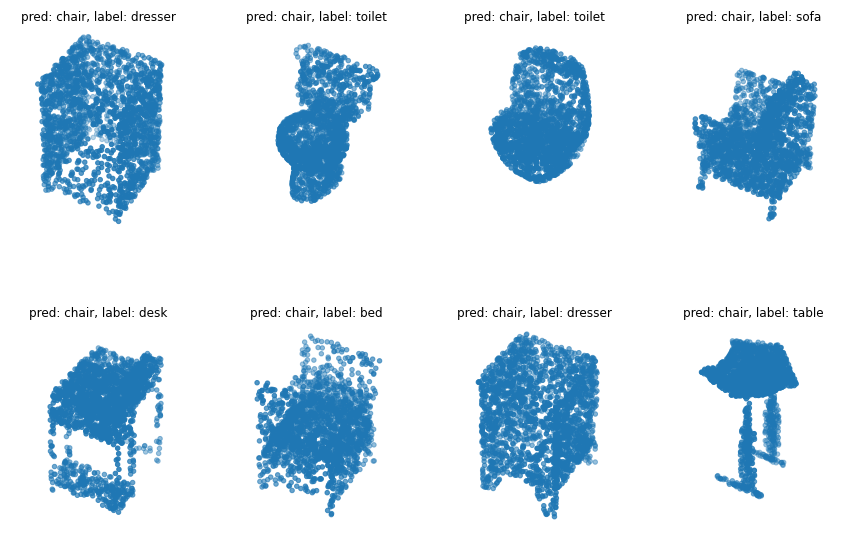

In [ ]:
data = test_dataset.take(1)

points, labels = list(data)[0]
points = points[:8, ...]
labels = labels[:8, ...]

# run test data through model
preds = model2.predict(points)
preds = tf.math.argmax(preds, -1)

points = points.numpy()

# plot points with predicted class and label
fig = plt.figure(figsize=(15, 10))
for i in range(8):
    ax = fig.add_subplot(2, 4, i + 1, projection="3d")
    ax.scatter(points[i, :, 0], points[i, :, 1], points[i, :, 2])
    ax.set_title(
        "pred: {:}, label: {:}".format(
            CLASS_MAP[preds[i].numpy()], CLASS_MAP[labels.numpy()[i]]
        )
    )
    ax.set_axis_off()
plt.show()
